## Background

| <font size=4>**Customer satisfaction classification** </font>|  .
:|:
|<font size=3>**The business problem:**</p>How can a US Airline company allocate</p>a given budget, to best address customers</p>with low to moderate satisfaction?</font><font face='Helvetica' size=2.5 color="blue"></p><br>**By Rami Zaboura and Amir Ashiri**</font> | ![](https://raw.githubusercontent.com/amirashiri/airline/2017f362a0781514b88e65abb1e768736f0ac6d8/airplane.jpg)

**The Goal**

Assuming that on a regular basis the airline company is able to collect various attributes related to customer satisfaction, but not necessarily the final/overall satisfaction experience, build a classification model which can accurately predict the overall experience, based on such attributes.The company may then allocate funds only to the customers who require it

**The data**

Passenger survey data based on about 130K customer trips, and collected over one year. The survery contains 22 satisfaction-related factors, such as passenger and trip attributes, service attributes, and on-boarding experience attributes.
14 of these 22 are survey answers by the customers, using a score between 1=worst and 5=best. Zero should reflect no-answer.
In addition, the data includes the "satisfaction" column which is the  overall satisfaction score: "satisfied", or "dissatisfied, or neutral".

**Method**

* Explore the data and look for important features
* Add features which might help the model
* Create a baseline model
* Train relevant classifiers, optimize and cross validate
* Add ensembling models using voting, bagging, and boosting
* Select the best model and run it on test data
* Analyze the selected model: error analysis, sensitivity, stability


## Setup & read data

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import seaborn as sns
!pip install scikit-learn==0.24.2
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score ,roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
!pip install xgboost==1.4.1
import xgboost as xgb
from xgboost import plot_tree
!pip install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats 
from scipy.stats import uniform
from statistics import *
!pip install lime
import lime
!pip install pytolemaic
from pytolemaic.pytrust import PyTrust
from pytolemaic.utils.dmd import DMD
from pprint import pprint
from lime import lime_tabular
import pickle
from os.path import join
from urllib.request import urlopen
from itertools import product
from IPython.display import Image
import time
import warnings
from google_drive_downloader import GoogleDriveDownloader as gdd
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams.update({'figure.max_open_warning': 0})
 
# re-load final model results based on local processing, to allow for better performance in scale
pre_calc = False

In [ ]:
url="http://raw.githubusercontent.com/amirashiri/airline/main/"
col_names = ['_', 'id', 'gender','customer_type', 'age', 'travel_type', 'travel_class', 'flight_distance', 'inflight_wifi', 'time_convenience',
             'online_booking_ease', 'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort', 'Inflight_entertainment',
             'on_board_service', 'leg_room', 'baggage_handling', 'checkin', 'inflight_service', 'cleanliness', 'departure_delay', 'arrival_delay',
             'satisfaction']
 
def read_data(df_name):
    df = pd.read_csv(f'{url}{df_name}.csv', names=col_names, skiprows=1)
    df.drop(columns='_', inplace=True)
    df.fillna(0, inplace=True)
    return df
 
train = read_data('train')
test = read_data('test')

## Data Preparation

Create categories and numerical values to be used in models

In [ ]:
def prep_data(df_name):
    df_name.drop(columns='id', inplace=True)
    df_name['gender_categ'] = df_name.gender.astype('category')
    df_name.gender = df_name.gender_categ.cat.codes
    df_name['customer_type_categ'] = df_name.customer_type.astype('category').cat.set_categories(['disloyal Customer', 'Loyal Customer'], ordered=True)
    df_name.customer_type = df_name.customer_type_categ.cat.codes
    df_name['travel_type_categ'] = df_name.travel_type.astype('category').cat.set_categories(['Personal Travel', 'Business travel' ], ordered=True)
    df_name.travel_type = df_name.travel_type_categ.cat.codes
    df_name['travel_class_categ'] = df_name.travel_class.astype('category').cat.set_categories(['Eco', 'Eco Plus', 'Business'], ordered=True)
    df_name.travel_class = df_name.travel_class_categ.cat.codes
    df_name['satisfaction_categ'] = df_name.satisfaction.astype('category')
    df_name.satisfaction = df_name.satisfaction_categ.cat.codes

prep_data(train)
prep_data(test)

First look at the data and our target

In [ ]:
train.head(3)

,gender,customer_type,age,travel_type,travel_class,flight_distance,inflight_wifi,time_convenience,online_booking_ease,gate_location,food_and_drink,online_boarding,seat_comfort,Inflight_entertainment,on_board_service,leg_room,baggage_handling,checkin,inflight_service,cleanliness,departure_delay,arrival_delay,satisfaction,gender_categ,customer_type_categ,travel_type_categ,travel_class_categ,satisfaction_categ
0,1,1,13,0,1,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0,Male,Loyal Customer,Personal Travel,Eco Plus,neutral or dissatisfied
1,1,0,25,1,2,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0,Male,disloyal Customer,Business travel,Business,neutral or dissatisfied
2,0,1,26,1,2,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1,Female,Loyal Customer,Business travel,Business,satisfied


In [ ]:
train.satisfaction.value_counts()

0    58879
1    45025
Name: satisfaction, dtype: int64

Check number zero scores, per column:

In [ ]:
train.loc[:,'inflight_wifi':'cleanliness'].apply(lambda x: x.value_counts(), axis=0).fillna(0).loc[0].sort_values(ascending=False)

time_convenience          5300.0
online_booking_ease       4487.0
inflight_wifi             3103.0
online_boarding           2428.0
leg_room                   472.0
food_and_drink             107.0
Inflight_entertainment      14.0
cleanliness                 12.0
inflight_service             3.0
on_board_service             3.0
checkin                      1.0
seat_comfort                 1.0
gate_location                1.0
baggage_handling             0.0
Name: 0, dtype: float64

Conceptually, these values should reflect an unanswered question However, looking at some of these columns vs. satisfaction, it looks like some should are very similar to value=5, while others are not. So, we'll try building a model excluding these rows, and compare it to a model which includes them. If it turns out that the first model is significantly better, we may try to predict or better adjust these zero values

In [ ]:
pd.crosstab(train.inflight_wifi, train.satisfaction, normalize='index', margins=True)

satisfaction,0,1
inflight_wifi,,
0,0.002578,0.997422
1,0.674552,0.325448
2,0.751336,0.248664
3,0.749420,0.250580
4,0.401031,0.598969
5,0.009242,0.990758
All,0.566667,0.433333


Number of survey questions the customer left unanswered

In [ ]:
for df in [train, test]:
    df['no_answers'] = df.apply(lambda row: sum([val == 0 for val in row.loc['inflight_wifi':'cleanliness']]), axis=1)

In [ ]:
train.no_answers.value_counts()

0    95704
1     3648
3     2048
2     1938
4      566
Name: no_answers, dtype: int64

Drop rows with unanswered questions

In [ ]:
for df in [train, test]:
    df.drop(df[df.no_answers > 0].index, inplace=True)
    df.drop(columns='no_answers', inplace=True)

## EDA

Features / Features / Target correlation

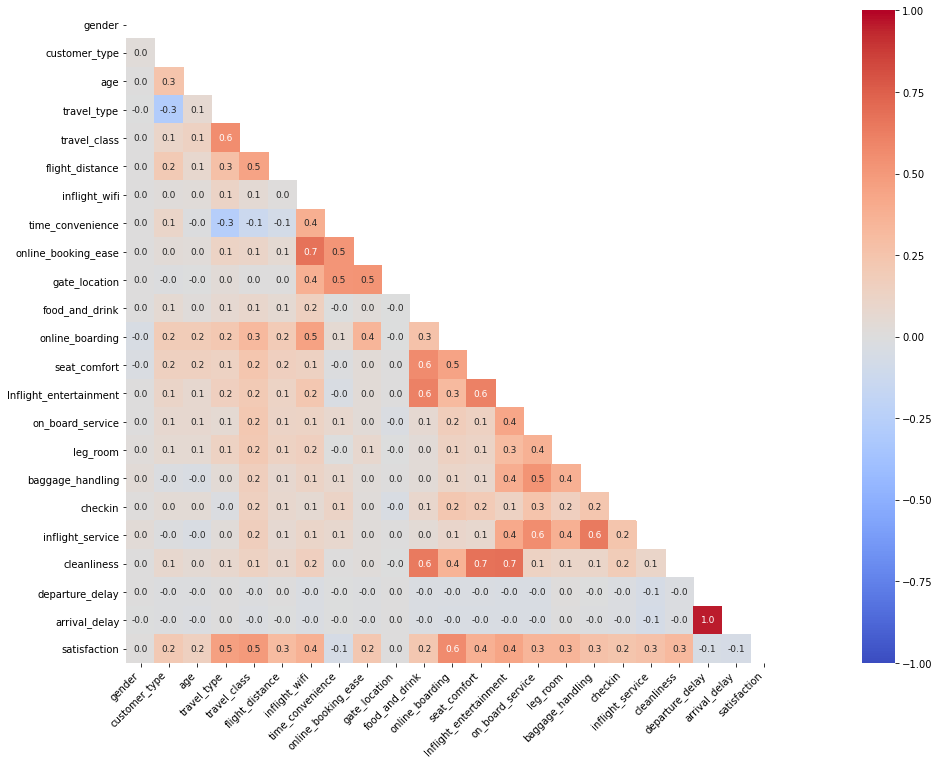

In [ ]:
plt.figure(figsize=(30,12))
df = train.loc[:, 'gender':'satisfaction'].corr()
sns.heatmap(df, annot=True, fmt='.1f', annot_kws={"size":9}, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, mask=np.triu(df))
plt.xticks(rotation=45, ha='right');

Interestingly, almost all disloyal customers travel for business. These could be employees who's casual travel is paid by their company ?

In [ ]:
pd.crosstab(train.customer_type_categ, train.travel_type_categ)

travel_type_categ,Personal Travel,Business travel
customer_type_categ,,
disloyal Customer,147,15238
Loyal Customer,29451,50868


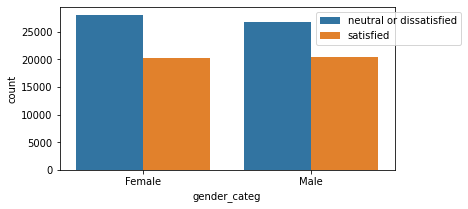

In [ ]:
plt.figure(figsize=(6,3))
cp=sns.countplot(data=train,x='gender_categ',hue='satisfaction_categ')
cp.legend(bbox_to_anchor= (0.75, 1) )

* no difference in satisfaction between males and females

Let's view the features correlated with satisfaction, together with their frequencies:

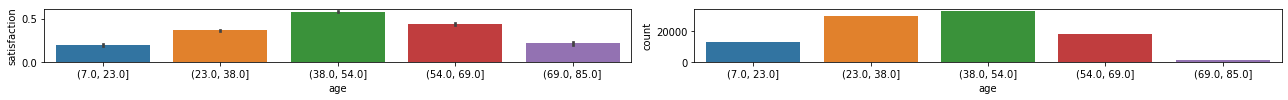

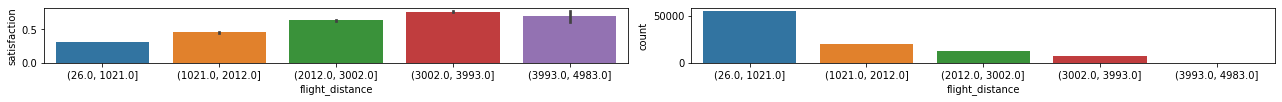

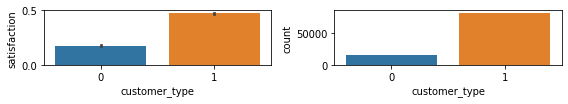

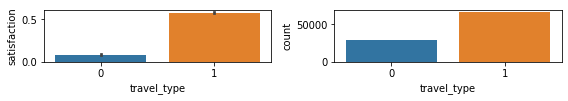

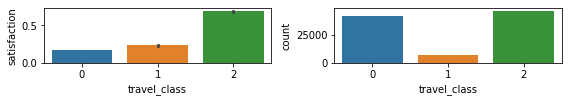

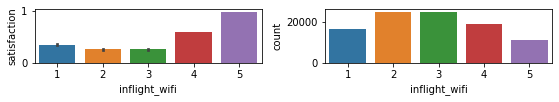

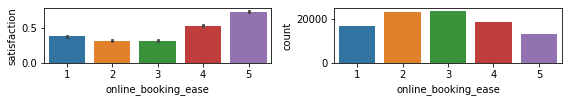

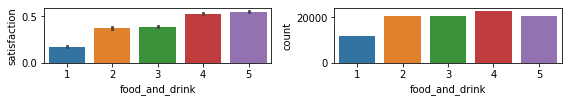

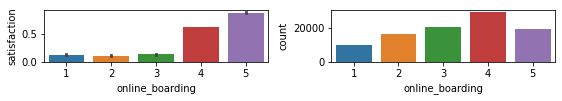

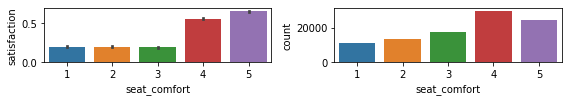

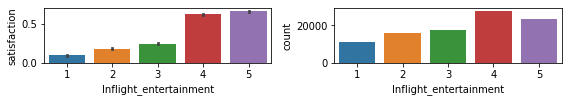

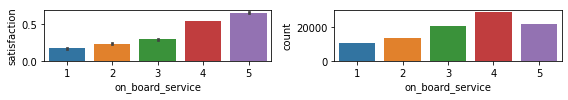

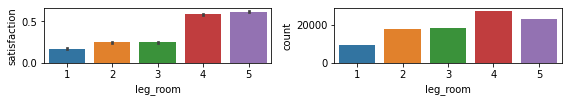

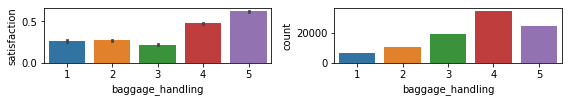

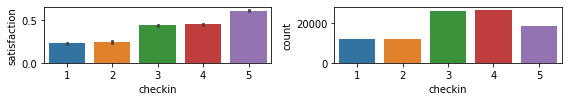

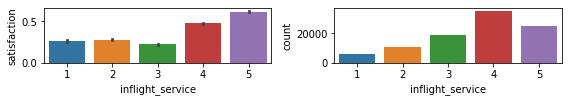

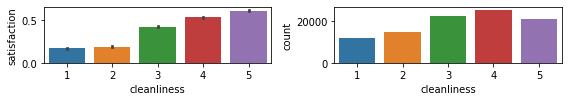

In [ ]:
grp_cols = ['age', 'flight_distance']
other_cols = [col for col in train.loc[:, :'cleanliness'].columns if col not in
              (grp_cols + ['gender', 'gate_location', 'time_convenience'])]
for col in grp_cols + other_cols:
    if col in grp_cols:
        x = pd.cut(train[col], 5, duplicates='drop', precision=0)
        width, height = 18, 1.5
    else:
        x = train[col]
        width, height = 8, 1.5
    fig, ax = plt.subplots(1, 2, figsize=(width, height), sharex=True);        
    sns.barplot(x=x, y=train.satisfaction, ax=ax[0]);
    sns.countplot(x=x, ax=ax[1]);
    fig.tight_layout(); 

inspect ages of customers

In [ ]:
print("average age: ",train.age.median())
print("oldest customer age: ",train.age.max())
print("youngest customer age: ",train.age.min())
# how many customers are under 18?
f'customers under the age of 18 account for {round((train[train.age<18].value_counts().sum()/len(train)*100),2)}% of the data'
under_18=train[train.age<18].satisfaction
print(f"percentage of under 18 satisfied customers: {round(under_18.sum()/len(under_18),3)}")
over_18=train[train.age>=18].satisfaction
print(f"percentage of over 18 satisfied customers: {round(over_18.sum()/len(over_18),3)}")

average age:  40.0
oldest customer age:  85
youngest customer age:  7
percentage of under 18 satisfied customers: 0.142
percentage of over 18 satisfied customers: 0.449


## Feature engineering

Create combinations of features by categorizing their meaning

In [ ]:
for df in [train, test]:
    position = df.columns.get_loc('satisfaction')
    df.insert(position, 'delay', df.departure_delay + df.arrival_delay)
    df.insert(position, 'pre_flight', df[[
        'online_booking_ease',
        'online_boarding',
        'checkin',
        'baggage_handling',
        'gate_location',
        'time_convenience']].mean(axis=1))

    df.insert(position, 'seating', df[[
        'seat_comfort',
        'leg_room',
        'cleanliness']].mean(axis=1))

    df.insert(position, 'service', df[[
    'inflight_wifi',
    'Inflight_entertainment',
    'food_and_drink',
    'on_board_service',
    'inflight_service']].mean(axis=1))

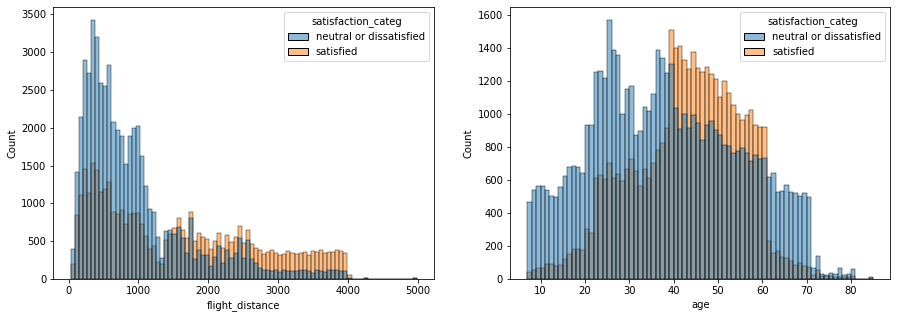

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5));
sns.histplot(data=train, x='flight_distance', hue='satisfaction_categ', ax=ax[0])
sns.histplot(data=train, x='age', hue='satisfaction_categ', ax=ax[1]);

it seems like there is a monotonic relation between flight distance and satisfaction, plus age and satisfaction until a certain age
so it would be worthy to create a new weight of evidence columns of these variables which specifies the importance of each subgroup in the variable in terms of seperating between the satisfied vs dissatisfied customer


In [ ]:
def woe(df,feature,target,nbins=-1):
    "create a new - weights of evidence columns"
    #continues feature- divide it into bins (subgroups)
    woe_list=[]
    if str(df[feature].dtype) != 'category':
        lvl=pd.qcut(df[feature],nbins,precision=0).cat.categories # divide the continues variable into  bins
        # iterate over each bin and extract its weight of evidence
        for i in range(nbins):
            lower_val, upper_val = lvl[i].left, lvl[i].right
            # count the number of "non-events" for the subgroup and divide by the total number of non events:
            non_events_subgroup = df[(df[feature]>=lower_val) & (df[feature]<=upper_val) & (df[target]=='neutral or dissatisfied')].shape[0]
            non_events_total= df[df[target]=='neutral or dissatisfied'].shape[0]
            non_events_ratio = non_events_subgroup / non_events_total
            # count the number of "events" for the subgroup and divide by the total number of events:
            events_subgroup = df[(df[feature]>=lower_val) & (df[feature]<=upper_val) & (df[target]=='satisfied')].shape[0]
            events_total = df[df[target]=='satisfied'].shape[0]
            events_ratio =  events_subgroup / events_total
            # weight of evidence is definde as the natural log of the division of events ratio by non events ratio
            woe_list.append(np.log(events_ratio/non_events_ratio))
        map_values(df,feature,woe_list,lvl,False)
      
        
    else:
        # categorical feature- already divided into bins
        lvl=df[feature].cat.categories
        for level in lvl:
            non_events_subgroup = df[(df[feature]==level) & (df[target]=='neutral or dissatisfied')].shape[0]
            non_events_total= df[df[target]=='neutral or dissatisfied'].shape[0]
            non_events_ratio = non_events_subgroup / non_events_total
            events_subgroup = df[(df[feature]==level)  & (df[target]=='satisfied')].shape[0]
            events_total = df[df[target]=='satisfied'].shape[0]
            events_ratio =  events_subgroup / events_total
            woe_list.append(np.log(events_ratio/non_events_ratio))
        map_values(df,feature,woe_list,lvl,True)
        
        
def map_values(df,feature,woe_list,lvl,categorical):
    "map the WOE values into the according bins"
    print("given feature:",feature)
    print("the feature's different levels and their WOEs:")
    print(list(zip(list(lvl),woe_list)))
    print("- "*300)
    if categorical==False:
        lvl=lvl.to_tuples()
        d={range(int(level[0]+1),int(level[1]+1)):woe_list[i] for i,level in enumerate(lvl)}
        apply_values(df,feature,lvl,d)
    else:
        d={level:woe_list[i] for i,level in enumerate(lvl)}
        apply_values(df,feature,lvl,d)
        

def apply_values(df,feature,lvl,d):
    woe_feature=[]
    for val in df[feature]:
        for key,value in d.items():
            if val in key:
                woe_feature.append(value)
                break   
    df.insert(df.columns.get_loc('satisfaction'),feature+"_woe",woe_feature)                

df_names=["train","test"]
for i,df in enumerate([train,test]):
    print("current dataset:",df_names[i])
    woe(df,'flight_distance','satisfaction_categ',5)
    woe(df,'age','satisfaction_categ',5)

current dataset: train
given feature: flight_distance
the feature's different levels and their WOEs:
[(Interval(30.0, 376.0, closed='right'), -0.4318307951447693), (Interval(376.0, 668.0, closed='right'), -0.49750771314418946), (Interval(668.0, 1085.0, closed='right'), -0.5004885227299593), (Interval(1085.0, 2119.0, closed='right'), 0.2693735464386085), (Interval(2119.0, 4983.0, closed='right'), 1.0983772461044936)]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

As we can see above, the WOEs indeed assigns more weight to older customers and longer flights. This way, we suggest our future models to consider these weights during classification

## Modeling

####Creating a baseline model

Let's create a baseline model, applying a semi-naive calculation: we'll create sub-groups by using four characteristics deemed important from a business standpoint: the customer type, the travel type, the travel class, and the flight distance. We'll then make a prediction by taking the mean satisfaction of each subgroup, rounded to 0 or 1:

              precision    recall  f1-score   support

           0       0.81      0.84      0.82     54947
           1       0.77      0.73      0.75     40757

    accuracy                           0.79     95704
   macro avg       0.79      0.79      0.79     95704
weighted avg       0.79      0.79      0.79     95704



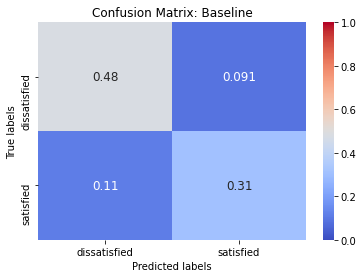

In [ ]:
baseline = round(train.groupby(['customer_type', 'travel_type', 'travel_class', pd.cut(train.flight_distance, 3)]).satisfaction.transform('mean'), 0)
cm = confusion_matrix(train.satisfaction, baseline, normalize='all')
ax = sns.heatmap(cm, annot=True, fmt='.2g', cmap='coolwarm', annot_kws={"size":12}, vmin=0, vmax=1);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: Baseline'); 
ax.xaxis.set_ticklabels(['dissatisfied', 'satisfied']);
ax.yaxis.set_ticklabels(['dissatisfied', 'satisfied']);
print(classification_report(train.satisfaction, baseline))

So our baseline model is not so bad... in order to justify a machine learning model, we'll need to to significantly better :)

####Split data into test and train

In [ ]:
train_sample = train.sample(10000, random_state=1)
X_train = train_sample.loc[:, 'gender':'age_woe']
y_train = train_sample['satisfaction']
 
X_test = test.loc[:, 'gender':'age_woe']
y_test = test['satisfaction']

In [ ]:
X_train = train.loc[:, 'gender':'age_woe']
y_train = train['satisfaction']

X_test = test.loc[:, 'gender':'age_woe']
y_test = test['satisfaction']

####Normalize all Features

In [ ]:
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.fit_transform(X_test)

####Create a general model handling class

In [ ]:
class MM():
    def __init__(self, model_name, X_train, y_train, model=None, search_params_dict=None,class_weight=None):
        self.X_train = X_train
        self.y_train = y_train
        self.model_name = model_name
        if class_weight is None:
            self.class_weight= {1:0.3, 0:0.7} # put more emphasis on penalizing the miss-identification of a unstatisfied customer, thus prefering the precision metric over the recall  
        else:
            self.class_weight=class_weight
        if model is None:
            if 'logistic' in model_name.lower():
                self.model = LogisticRegression(class_weight=self.class_weight,random_state=1)
                self.search_params_dict = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'none'])
            elif 'forest' in model_name.lower():
                self.model = RandomForestClassifier(class_weight=self.class_weight,random_state=1)
                self.search_params_dict = {"max_depth":[3,5,7,10], "min_samples_split":[8,12,16,24,30],"min_samples_leaf":[50,100,150,200], "n_estimators":[100,250,500,750,1000,1500,2000],
                                           "max_features": ['auto', 'sqrt',0.2]}
            elif 'gbm' in model_name.lower():
                fixed_params={"class_weight":self.class_weight,'objective': 'binary', 'metric': 'auc','is_unbalance':True,'bagging_freq':5,'boosting':'dart','num_boost_round':300,'early_stopping_rounds':30,'random_state':1}
                self.model = lgb.LGBMClassifier(**fixed_params)
                self.search_params_dict = {'learning_rate': uniform(loc=0.0001,scale=1), 'max_depth': [3,7,15],'num_leaves': [16,32,50],
                                           'feature_fraction': uniform(0,1),'subsample': uniform(loc=0,scale=1)}
            elif 'xgb' in model_name.lower():
                self.model = xgb.XGBClassifier(class_weight=self.class_weight,silent=True, verbosity=0, random_state=1)
                self.search_params_dict = {"learning_rate":uniform(loc=0.001,scale=1), "max_depth":[ 3, 4, 5, 6, 8, 10, 12, 15], "min_child_weight":[ 1, 3, 5, 7 ],
                                    "gamma":uniform(loc=0.001,scale=1), "colsample_bytree" : np.linspace(0.2,0.7,5) }
            elif 'catb' in model_name.lower():
                self.model = CatBoostClassifier(class_weights=self.class_weight,verbose=False, random_state=1)
                self.search_params_dict = {"n_estimators": [10, 50, 100,200,500,1000],"learning_rate":uniform(loc=0.0001,scale=1),
                                    "sampling_frequency":["PerTree","PerTreeLevel"],"max_depth":[3,7,9,15,24]}
        else:
            self.model = model
            self.search_params_dict = search_params_dict

    def fit(self):
        self.model.fit(self.X_train, self.y_train)
        return self

    def predict(self, X):
        return self.model.predict(X)
    
    # calculate cross validation using AUC and accuracy, and return their mean and std
    def score_model(self, X, y):
        print('scoring' ,self.model_name)
        results = pd.DataFrame()
        results['classifier'] = [self.model_name]
        cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
        scores = cross_val_score(estimator=self.model , X=X, y=y, cv=cv, scoring='precision', n_jobs=-1)
        results['precision_mean'] = [scores.mean()]
        results['precision_std'] = [scores.std()]
        return (results, scores)

    # calculate score after finding optimal parameters
    def Randomized_Search_CV(self):
        print('regularizing', self.model_name)
        random_search=RandomizedSearchCV(self.model, self.search_params_dict,scoring='precision',cv=5,n_iter=10, random_state=0)
        random_search.fit(self.X_train, self.y_train)        
        self.best_params = random_search.best_params_
        self.best_score = random_search.best_score_
        self.model = random_search.best_estimator_
        results, scores = self.score_model(self.X_train, self.y_train)
        results['best_randomized_params'] = [self.best_params]
        results['best_randomized_score'] = [self.best_score]
        return (results, scores)

####Create, optimize, and score instances of different models

In [ ]:
def add_model(model_name, model=None, search_params_dict=None):
    global optimized_classifiers, results
    
    mm = MM(model_name, X_train, y_train, model, search_params_dict)
    model_results, model_scores = mm.Randomized_Search_CV()
    optimized_classifiers.append(mm)
    results = pd.concat([results, model_results])
    scores[model_name] = model_scores

def get_clf(model_name):
    global optimized_classifiers

    clf_index = [clf.model_name.lower() for clf in optimized_classifiers].index(model_name.lower())
    return optimized_classifiers[clf_index]    

In [ ]:
if not pre_calc:
    optimized_classifiers = list()
    results = pd.DataFrame()
    scores = pd.DataFrame()
    add_model('Random Forest')
    add_model('Logistic Regression')
    add_model('LightGBM')
    add_model('XGBoost')
    add_model('CATBoost')

regularizing Random Forest
scoring Random Forest
regularizing Logistic Regression
scoring Logistic Regression
regularizing LightGBM
scoring LightGBM
regularizing XGBoost
scoring XGBoost
regularizing CATBoost


#### Add bagging classifiers

In [ ]:
if not pre_calc:
    logistic_clf = get_clf('logistic regression').model
    bagging_log_clf = BaggingClassifier(base_estimator=logistic_clf, n_estimators=100, random_state=1)
    bagging_log_params_grid = {'n_estimators': [50, 100, 200]}
    add_model('Log-Bagging', bagging_log_clf, bagging_log_params_grid)

    dt_clf = DecisionTreeClassifier(max_depth=5)
    bagging_dt_clf = BaggingClassifier(base_estimator=dt_clf, n_estimators=100, random_state=1)
    bagging_dt_params_grid = {'n_estimators': [100, 200, 300], 'base_estimator__max_depth': [5, 10, 20]}
    add_model('Dtree-Bagging', bagging_dt_clf, bagging_dt_params_grid)

    knn_clf = KNeighborsClassifier(n_neighbors=5)
    bagging_knn_clf = BaggingClassifier(base_estimator=knn_clf, n_estimators=100, random_state=1)
    bagging_knn_params_grid = {'n_estimators': [50, 100, 200], 'base_estimator__n_neighbors': [5, 10, 20]}
    add_model('KNN-Bagging', bagging_knn_clf, bagging_knn_params_grid)

####Add a voting classifier

In [ ]:
if not pre_calc:
    # changed to lightGBM - since it got better results
    voting_estimators = (
        ('LightGBM', get_clf('xgboost').model),
        ('catboost', get_clf('catboost').model)
    )
    voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')
    vote_rng = np.arange(0.1, 1.1, 0.1)
    vote_grid = [[i,j] for i in vote_rng for j in vote_rng]
    voting_params_grid = {'weights': vote_grid}
    add_model('Voting', voting_clf, voting_params_grid)

#### Add boosting (and more bagging) classifiers




In [ ]:
if not pre_calc:
    # Adaboost: logistic
    logistic_clf = get_clf('logistic regression').model
    adaboost_log_clf = AdaBoostClassifier(base_estimator=logistic_clf, n_estimators=200, learning_rate=0.01, random_state=1)
    adaboost_log_params_grid = {'n_estimators': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.1]}
    add_model('Log-Adaboost', adaboost_log_clf, adaboost_log_params_grid)

    # Gradient boost (desicion-tree based)
    grdboost_clf = GradientBoostingClassifier(max_depth=3, n_estimators=200, learning_rate=0.01, random_state=1)
    grdboost_params_grid = {'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.02, 0.03]}
    add_model('Log-GradientBoost', grdboost_clf, grdboost_params_grid)

## Model Selection

####View results of all classifiers
*(or, if pre_calc is true, load the pre-calculated results,scores,optimized_classifiers after the RandomizedSearchCv + CrossvalidationScoring procedures)*

In [ ]:
if pre_calc:
    # load scores:
    gdd.download_file_from_google_drive(file_id='1XVChhW9ArgeHBwbMHfs1UgmWjpm8Cdcn', dest_path='./scores')
    scores= pd.read_pickle('scores')
    # load results:
    gdd.download_file_from_google_drive(file_id='1L3JmSqJdPEcV7_bjnAwom-fr3c78laIA', dest_path='./results_after_optimization')
    results=pd.read_pickle("results_after_optimization")
    # load optimized classifiers:
    gdd.download_file_from_google_drive(file_id='12h6RTgnxtfzFdA64QqJcusq2EIhxbpUk', dest_path='./optimized_classifiers')
    optimized_classifiers=pd.read_pickle("optimized_classifiers")

results after optimization:

In [ ]:
results.sort_values(by="best_randomized_score",ascending=False)

Precision based on the cross-validation results vectors

In [ ]:
plt.subplots(figsize=(10,5))
sns.boxplot(data=scores)
plt.xticks(fontsize=14)
plt.xticks(rotation=45, ha='right');
plt.title('Precision per CV results')
plt.show()

As we can see, the **CatBoostClassifier** gets the best results, while being simpler than the 2nd & 3rd in line, which are the voting classifier and Log-Adaboost.

in the below ROC curves, the **Xgbclassifier curve** is the closest to a perfect curve, overtaking all the others

Show ROC curve for all models

In [ ]:
final = get_clf('CatBoost')
final_model=final.model
fix, ax = plt.subplots(figsize=(16,8))
for i,clf in enumerate(optimized_classifiers):
    if i==8:
        continue
    fig = plot_roc_curve(clf.model, X_train, y_train, ax=ax)
fig.figure_.suptitle("ROC curve comparison")
plt.xlim(0,1)
plt.show()

## Model Inspection

####Selected model confusion matrix: train vs. test

In [ ]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
for i, data, split in zip(range(2), [(y_train, y_train_pred), (y_test, y_test_pred)], ['Train', 'Test']):
    cm = confusion_matrix(*data, normalize='all')
    ax = sns.heatmap(cm, annot=True, fmt='.2g', cmap='coolwarm', annot_kws={"size":12}, vmin=0, vmax=1, ax=axs[i]);
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(split, fontsize=16)
    ax.xaxis.set_ticklabels(['dissatisfied', 'satisfied'])
    ax.yaxis.set_ticklabels(['dissatisfied', 'satisfied'])
fig.tight_layout()

Classification reports

In [ ]:
print(classification_report(y_train, y_train_pred))

In [ ]:
print(classification_report(y_test, y_test_pred))

#### Model Visualization

First levels of the best_iteration CatBoost tree

In [ ]:
from catboost import CatBoostClassifier, Pool
X=X_train.sample(10000)
y=y_train.sample(10000)
# show visulization on subset of data - clearer plot 
is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)
cat_features_index = np.where(is_cat)[0]
pool = Pool(X, y, cat_features=cat_features_index, feature_names=list(X.columns))

final_model.plot_tree(
    tree_idx=0,
    pool=pool)

Feature importance

In [ ]:
feat_importances = pd.Series(final_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feat_importances.nlargest(15).plot(kind='barh')

Decision region plotting :

Take worst preforming estimator(logistic regression), best performing estimator(CatBoost), and plot their decision region visulization based on 3-D feature space, the space will be picked according to most imporant features to the model

* features importance are the exact same in all models, we will use the top 3 as our 3-D feautre space for plotting the decision boundary

In [ ]:
top_3_features=['travel_type','inflight_wifi','customer_type']
X_train_important=X_train[top_3_features]
X_test_important=X_test[top_3_features]
# adjust the models fitting based on top features only
final_model.fit(X_train_important,y_train)
opt_logistic=get_clf("logistic regression").model
opt_logistic.fit(X_train_important,y_train)
X_train_Space = np.asarray(X_train_important, dtype=np.float32)
X_test_Space= np.asarray(X_test_important, dtype=np.float32)
train_target=np.asarray(y_train)
test_target=np.asarray(y_test)
print(f"classification report on new feature space:\n\nlogistic regression:\n{classification_report(y_test,opt_logistic.predict(X_test_important))}\nCatBoost:\n{classification_report(y_test,final_model.predict(X_test_important))}")
# plotting decision regions:
gs = gridspec.GridSpec(2,2)
gs_positions=list(product([0,1],repeat=2))
models=[opt_logistic,opt_logistic,final_model,final_model] 
features=[X_train_Space,X_test_Space,X_train_Space,X_test_Space]
targets=[train_target,test_target,train_target,test_target]
labels=["logistic regression train","logistic regresion test","CatBoost train","CatBoost test"] 
plt.figure(figsize=(12,10))
for clf, lab, pos,ft,tr in zip(models,labels,gs_positions,features,targets):
    ax = plt.subplot(gs[pos[0], pos[1]])
    fig = plot_decision_regions(X=ft, y=tr, clf=clf,
                            filler_feature_values={2: 0.0001}, 
                            filler_feature_ranges={2: 5},
                           legend=2)
    
    handles, names = ax.get_legend_handles_labels()
    plt.title(lab)
    plt.legend(handles,['unsatisfied', 'satisfied'],loc='upper left',fontsize='small')
plt.show()

first of all, looking at these plots, we can see that the CatBoostClassifier is a valid model, since the plots on the train and test data set and very simillar

logisitc regression: bad precision, bad recall

catBoost: good precision , terrible recall

as can be seen from the plots, CatBoostClassifier  is able to capture non-linear boundaries, both models exhibit good precision in these visulizations, but mainly show poor recall ability , which is influened by our weights division

#### Error Analysis

Prediction vs target Distribution

In [ ]:
plt.figure(figsize=(5,5))
plt.subplot(2,1,1)
plt.title("Prediction Vs Target Distribution",fontsize=18)
sns.distplot(final_model.predict(X_test))
plt.xlabel("predicion distribution",fontsize=12)
plt.subplot(2,1,2)
sns.distplot(y_test)
plt.xlabel("target distribution",fontsize=12)

* same distribution in both target and predicted outcome

In [ ]:
# refit the data on the whole training set
final_model.fit(X_train,y_train)
wrong_index=y_test[(y_test-final_model.predict(X_test))!=0].index # get row locations of missclassifications
miss_classified_features=X_test.loc[wrong_index,:]
miss_classified_target=y_test.loc[wrong_index]
f"the percentage of miss classified data points out of all dataset is: {round((miss_classified_target.shape[0]/X_test.shape[0]),3)*100}%"

divide the errors to misses - (recall errors) and false alarms -( precision errors)




In [ ]:
# miss (actual=1,prediction=0) : recall mistake
miss_classified_target_recall=miss_classified_target[miss_classified_target==1]
miss_classified_features_recall=X_test.loc[miss_classified_target_recall.index,:]
print(f"the percentage of recall type of missclassification is: {round((miss_classified_target_recall.shape[0]/X_test.shape[0]),3)*100}%")
print()
miss_classified_features_recall.mean()

* almost all of the mistakes are recall mistakes, which is what we wanted for our business problem
* on average , the features values in these cases are negative, which makes sense since it encourages the model to miss-classify it as unstaisfied based on its previous experience from the train model, where in this case it actually indicates a satisfied customer, this can also lead us to think that our model suffers from population stability, since this shows a different population distribution and miss classification

In [ ]:
# looking at false alarms (precision mistakes) (actual=0,prediction=1)
miss_classified_target_precision=miss_classified_target[miss_classified_target==0]
miss_classified_features_precision=X_test.loc[miss_classified_target_precision.index,:]
miss_classified_features_precision.mean()

* here it is almost the opposite case, most values on average are positive, which leads the model to wrongfully classify the data as satisfied, when in reality the customer is unstaisfied

Group Level Errors:

see average combination of values, for a subgroup in the data that lead to errors  , we chose the 4 important features previously discovered to account for this group

In [ ]:
miss_classified_features[['inflight_wifi','travel_type','travel_class','online_boarding']].hist()
print(miss_classified_features[['inflight_wifi','travel_type','travel_class','online_boarding']].median())

the average value in each column is a scaled value, to interpret what it means, we need to look back at the origional column values, and see which value is the closest to the scaled averages of this subgroup

In [ ]:
train.travel_type.unique()
print("inflight wifi:")
print()
print("before scaling:")
print(list(pd.Series(train.inflight_wifi.unique()).sort_values()))
print()
print("after scaling:")
print(list(pd.Series(miss_classified_features.inflight_wifi.unique()).sort_values()))
print()
print("travel class:")
print()
print("before scaling:")
print(list(pd.Series(train.travel_class.unique()).sort_values()))
print()
print("after scaling:")
print(list(pd.Series(miss_classified_features.travel_class.unique()).sort_values()))
print()
print("travel type:")
print()
print("before scaling:")
print(list(pd.Series(train.travel_type.unique()).sort_values()))
print()
print("after scaling:")
print(list(pd.Series(miss_classified_features.travel_type.unique()).sort_values()))
print()
print("online boarding:")
print()
print("before scaling:")
print(list(pd.Series(train.online_boarding.unique()).sort_values()))
print()
print("after scaling")
print(list(pd.Series(miss_classified_features.online_boarding.unique()).sort_values()))
print()

* inflight wifi = 0.95 (closest to 3- average level of wifi satisfaction )

* travel type = 0.66 (closest to 1 - business travel)

* travel class  = -1.08 (closest to 0 - eco )

* online boarding = 0.51 (closest to 4- high level of satisfaction regarding online boarding)

* average combination of values, some are high, some are average, and some are low which misleads the model


#### Sensitivity Analysis

Conclusions:


1.   The most important features are travel_type and inflight_wifi, 

2.   Many features have low sensitivity and little value - this may call for reducing number of features by removing the least important ones, or using regularization


In [ ]:
feature_names = X_train.columns.tolist()
pytrust = PyTrust(
    model=final.model,
    xtrain=X_train, ytrain=y_train,
    xtest=X_test[:10000], ytest=y_test[:10000],
    columns_meta={DMD.FEATURE_NAMES: feature_names},
    metric='auc')
report = pytrust.sensitivity_report
report.plot()

In [ ]:
pprint(report.to_dict(), width=120)

#### Stability Analysis


a) testing our models on different subsets of the data (of same size), and monitoring its accuracy to different subsets of data


In [ ]:
# take 4 different subsets consisting of 10000 samples, and check the models performance on all of them
final_model.fit(X_train,y_train)
accs=[]
y_trained=y_train.sample(10000)
y_tested=y_test.sample(10000)
sub11=X_train.sample(10000)
sub12=X_test.sample(10000)
final_model.fit(sub11,y_trained)
accs.append(accuracy_score(y_tested,final_model.predict(sub12)))
sub21=X_train.sample(10000)
sub22=X_test.sample(10000)
final_model.fit(sub21,y_trained)
accs.append(accuracy_score(y_tested,final_model.predict(sub22)))
sub31=X_train.sample(10000)
sub32=X_test.sample(10000)
final_model.fit(sub31,y_trained)
accs.append(accuracy_score(y_tested,final_model.predict(sub32)))
sub41=X_train.sample(10000)
sub42=X_test.sample(10000)
final_model.fit(sub41,y_trained)
accs.append(accuracy_score(y_tested,final_model.predict(sub42)))
print(list(zip(["first subset accuracy->","second subset accuracy->","third subset acacuracy->","fourth subset accuracy->"],accs)))

* similar accuracy in different subsets of data

b) Population Stability Index (PSI) : we want to measure how much our predicted outcome has shifted in distribution  between two different samples of a population,  it’s a good indication if the model has stopped predicting accurately due to significant changes in the population distribution that can occur as a result of a economic crisis, or wrong data sourcing etc.....

* sorting all columns to ensure significant changes in the population distribution

In [ ]:
 # sort by descending order so we can check the effect of sampling, since we want different samples
 # to have different distributions in a data where most of its features are categorical thus not ordering it results in simillar distribution for different samples
odd_population=X_test.apply(lambda x: x.sort_values(ascending=False).values)
expected_population=X_test.sample(10000)  # a population that the model expects to have
expected_scores=final_model.predict(expected_population)
unexpected_population=odd_population.tail(10000) # a population with a new distribution odd to the model
unexpected_scores=final_model.predict(unexpected_population)
print("expected population:")
expected_population.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)  
plt.tight_layout(rect=(0, 0, 2, 2))   

In [ ]:
print("new population distribution:")
unexpected_population.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)  
plt.tight_layout(rect=(0, 0, 2, 2))

* we can see that the populations are different in terms of distribution in some feautres

In [ ]:
 def psi(expected_array, actual_array, buckets,buckettype):
        """function which aids us in understanding how much our prediction has shifted
        in distribution between two samples"""
        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)
psi_value=psi(expected_scores,unexpected_scores,10,'bins')
f'final model population stability index value: {psi_value}'

Interpreation of the psi result:

* PSI<0.1 --> no change is needed

* 0.1=<PSI<=0.2 --> slight change is needed

* PSI>= 0.2 --> significant change is required

so in our case we don't need to make changes in the model


* looking at the MSE plots, we can see that higher complexity leads to lower train error, which means lower bias, on the other hand it leads to increased test error, which means higher variance, our aim is to prune the model while not hurting the bias too much


In [ ]:
accuracy_score(y_test,final_model.fit(X_train,y_train).predict(X_test))

<font size=3>And now it's time for playing with the LIME package<br><br></font>![](https://raw.githubusercontent.com/amirashiri/airline/009cb498eefd69a999d4afc5107549e218d07629/lemon.jpg)
<br><br>
LIME = Local interpretable model-agnostic explanations, is a model-agnostic tool Local interpretable model-agnostic explanations, is a model-agnostic tool to display to relevan model's paramters, affecting any specific classification decision</font>

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['dissatisfied', 'satisfied'],
    mode='classification'
)

In [ ]:
while True:
    row_inp = input('Choose a passenger trip from 1 to 10,000, or 0 to quit  ')
    print()
    print()
    if not row_inp.isnumeric():
        continue
    row = int(row_inp)
    if row == 0:
        break
    exp = explainer.explain_instance(
        data_row=X_test.iloc[row], 
        predict_fn=final.model.predict_proba)
    exp.show_in_notebook(show_table=True)
    time.sleep(2)
    print()
    print()

## Bonus Section : customized voter with dynamic weights

#### Take our best classifiers so far, and per each value, decide which model is better to use, according to its K-nearest-neighbors

In [ ]:
class ComparingVoter():
    def __init__(self, estimators, selected_cols):
        self.estimators = estimators
        self.knn_models = []
        self.selected_cols = selected_cols
    
    def fit(self, X, y):
        for estimator in self.estimators:
            # create y_est = the prediction score, used as a new label by the KNN regressor
            y_est = pd.DataFrame(estimator.predict_proba(X))[1]
            y_est.index = X.index
            y_est = pd.concat([y_est, y], axis=1)
            y_est.columns = ['pred', 'label']
            y_est = y_est.assign(score = np.where(y_est.label == 1, y_est.pred, 1-y_est.pred))[['score']]

            # fit and optimize the KNN regressor
            knn = KNeighborsRegressor()
            params_dist = {'n_neighbors': list(range(1,50)), 'weights': ['uniform', 'distance'], 'p': [1, 2]}
            grid = RandomizedSearchCV(knn, param_distributions=params_dist, cv=5, n_iter=10, n_jobs=-1, random_state=1)
            grid.fit(X[self.selected_cols], y_est)
            knn = grid.best_estimator_
            self.knn_models.append(knn)
            cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
            scores = cross_val_score(estimator=knn , X=X, y=y_est, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
            print(f'Best KNN params: {grid.best_params_} with cross validation score {scores.mean() :.2f} +/-{scores.std() :.2f}')
        return self

    def predict_(self, X):
        knn_probs = [knn.predict(X[self.selected_cols]) for knn in self.knn_models]
        weights = [knn_prob / sum(knn_probs) for knn_prob in knn_probs]
        probs = [estimator.predict_proba(X) for estimator in self.estimators]
        probs = [[p[1] for p in prob] for prob in probs]
        pred=[]
        for i in range(len(X)):
            prob = 0
            for est in range(len(self.estimators)):
                prob += weights[est][i][0] * probs[est][i]
            pred.append(prob)
        return pred

    def predict(self, X):
        return [round(x) for x in self.predict_(X)]

    def predict_proba(self, X):
        proba = pd.DataFrame(self.predict_(X))
        proba.insert(0, '1', 1-proba.iloc[:,0])
        proba.columns=[0, 1]
        return proba.values

Build our comparing-voter using the already-fitted XGBoost and CATBoost classifiers


In [ ]:
selected_models = [get_clf('xgboost').model.fit(X_train,y_train), get_clf('catboost').model.fit(X_train,y_train)]
selected_cols = ['online_boarding', 'travel_type', 'inflight_wifi', 'customer_type', 'travel_class']
c_voter_clf = ComparingVoter(selected_models, selected_cols)
c_voter_clf.fit(X_train, y_train);

Check the classification report of the new voter on train and test

In [ ]:
print('Train\n')
print(classification_report(y_train, c_voter_clf.predict(X_train)))
print('\nTest\n')
print(classification_report(y_test, c_voter_clf.predict(X_test)))

## Additional Ideas

1. Apply pruning methods
2. Add run time to model selection criteria
3. Compare models with and without features selection and removing correlations
4. Predict values of questions without answers
5. Try models with/without feature selection & reduction